In [1]:
from keras.layers import BatchNormalization, LeakyReLU, Activation, Dropout
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten, Dense, Reshape, Input
from keras.models import Model
from keras import backend as K
import numpy as np

In [2]:
class AutoEncoder:
  def __init__(self, input_dim, 
               encoder_filters,
               encoder_kernel_size,
               encoder_strides,
               decoder_filters,
               decoder_kernel_size,
               decoder_strides,
               dense_dim):
    self.input_dim = input_dim
    self.encoder_filters = encoder_filters
    self.encoder_kernel_size = encoder_kernel_size
    self.encoder_strides = encoder_strides
    self.decoder_filters = decoder_filters
    self.decoder_kernel_size = decoder_kernel_size
    self.decoder_strides = decoder_strides
    self.dense_dim = dense_dim
  
  def build(self):
    encoder_layer = Input(shape = self.input_dim)

    x = encoder_layer

    for i in range(len(self.encoder_filters)):
      conv_layer = Conv2D(
          filters = self.encoder_filters[i],
          kernel_size = self.encoder_kernel_size[i],
          strides = self.encoder_strides[i],
          padding = 'same'
      )

      x = conv_layer(x)
      x = LeakyReLU()(x)
      x = BatchNormalization()(x)
      x = Dropout(rate = 0.3)(x)
    
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(self.dense_dim, name = 'encoder_output')(x)

    encoder = Model(encoder_layer, latent, name = 'encoder')

    decoder_layer = Input(shape = (self.dense_dim,))
    x = Dense(np.prod(shape_before_flattening[1:]))(decoder_layer)
    x = Reshape((shape_before_flattening[1], shape_before_flattening[2], shape_before_flattening[3]))(x)

    for i in range(len(self.decoder_filters)):
      conv_transpose_layer = Conv2DTranspose(
          filters = self.decoder_filters[i],
          kernel_size = self.decoder_kernel_size[i],
          strides = self.decoder_strides[i],
          padding = 'same'
      )

      x = conv_transpose_layer(x)
      x = LeakyReLU()(x)
      x = BatchNormalization()(x)
      x = Dropout(rate = 0.3)(x)

    x = Conv2DTranspose(filters = (self.input_dim)[2], kernel_size = (3, 3), padding = 'same')(x)

    outputs = Activation("sigmoid")(x)

    decoder = Model(decoder_layer, outputs, name = 'decoder')

    autoencoder = Model(encoder_layer, decoder(encoder(encoder_layer)), name = 'autoencoder')

    return (encoder, decoder, autoencoder)


In [3]:
from keras.optimizers import Adam
from keras.datasets import mnist

EPOCHS = 30
BATCH_SIZE = 32

((trX, _), (teX, _)) = mnist.load_data()

trX = np.expand_dims(trX, axis = -1)
teX = np.expand_dims(teX, axis = -1)
trX = trX.astype('float32') / 255.0
teX = teX.astype('float32') / 255.0

autoencoder = AutoEncoder(input_dim = (28, 28, 1),
            encoder_filters = [32, 64, 64, 64],
            encoder_kernel_size = [3, 3, 3, 3],
            encoder_strides = [1, 2, 2, 1],
            decoder_filters = [64, 64, 32],
            decoder_kernel_size = [3, 3, 3, 3],
            decoder_strides = [1, 2, 2, 1],
            dense_dim = 16)

(encoder, decoder, autoencoder) = autoencoder.build()
opt = Adam(lr=0.0005)
autoencoder.compile(loss='mse', optimizer = opt)

AE = autoencoder.fit(trX, trX, validation_data = (teX, teX), epochs = EPOCHS, batch_size = BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/30
1875/1875 [==============================] - 65s 18ms/step - loss: 0.0592 - val_loss: 0.0154
Epoch 2/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0199 - val_loss: 0.0128
Epoch 3/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0171 - val_loss: 0.0120
Epoch 4/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0159 - val_loss: 0.0112
Epoch 5/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0154 - val_loss: 0.0108
Epoch 6/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0149 - val_loss: 0.0105
Epoch 7/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0147 - val_loss: 0.0106
Epoch 8/30
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0145 - val_loss: 0.0103
Epoch 9/30
1875/1875 [==============================] - 33s 17ms/step - loss: 0.0144 - val_loss: 0.0101

True

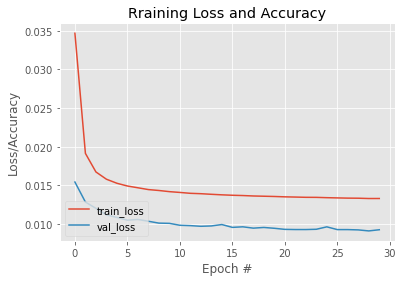

In [4]:
import matplotlib.pyplot as plt

import argparse
import cv2

ap = argparse.ArgumentParser()
ap.add_argument('-f')
ap.add_argument("-s", "--samples", type=int, default = 8, 
                help = "# number of samples to visualize when decoding")
ap.add_argument("-o", "--output", type=str, default="output.png",
                help = "path to output visualzation file")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
                help = "path to output plot file")
args = vars(ap.parse_args())

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, AE.history["loss"], label='train_loss')
plt.plot(N, AE.history["val_loss"], label='val_loss')
plt.title("Rraining Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='lower left')
plt.savefig(args["plot"])

decoded = autoencoder.predict(teX)
outputs = None

for i in range(0, args["samples"]):
    # grab the original image and reconstructed image
    original = (teX[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    
    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

    # if the outputs array is empty, initialize it as the current
	# side-by-side image display
    if outputs is None:
	    outputs = output
    # otherwise, vertically stack the outputs
    else:
	    outputs = np.vstack([outputs, output])
     
cv2.imwrite(args["output"], outputs)

In [5]:
autoencoder.save("model.h5")